<a href="https://colab.research.google.com/github/ccarpenterg/LearningPyTorch1.x/blob/master/04_cifar_10_challenging_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR-10: A More Challenging Dataset for CNNs

(Google has upgraded to pytorch 1.2.0 and torchvision 0.4.0, but since we've been using pytorch 1.1.0 and torchvision 0.3.0, we'll install those version and upgrade to the new ones at some point in the future)

In [0]:
!pip install torch==1.1.0 torchvision==0.3.0

In [0]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import statistics

In [2]:
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

PyTorch version: 1.3.1
Torchvision version: 0.4.2


In [0]:
class BasicCNN(nn.Module):
    
    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*4*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [4]:
cuda = torch.device('cuda')

model = BasicCNN(3, 10)
model.to(cuda)

BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
dataset_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = CIFAR10('./cifar10', train=True, download=True, transform=dataset_transform)
valid_set = CIFAR10('./cifar10', train=False, download=True, transform=dataset_transform)

print(train_set.data.shape)
print(valid_set.data.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 87972293.20it/s]                               


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

In [7]:
x = torch.randn(128, 3, 32, 32, device=cuda)
output = model(x)
print(output.shape)

torch.Size([128, 10])


## Training the Model

**Optimizer: Stochastic Gradient Descent**

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

**Train function**

In [0]:
def train(model, loss_fn, optimizer):
    model.train()
    
    train_batch_losses = []
    
    for batch, labels in train_loader:
        batch = batch.to(cuda)
        labels = labels.to(cuda)
        
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        train_batch_losses.append(float(loss))
        
        mean_loss = statistics.mean(train_batch_losses)
        
    return mean_loss

**Validation function**

In [0]:
def validate(model, loss_fn, optimizer):
    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        validation_batch_losses = []
        
        for batch, labels in valid_loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)
            
            labels_pred = model(batch)
            loss = loss_fn(labels_pred, labels)
            
            validation_batch_losses.append(float(loss))
            
            mean_loss = statistics.mean(validation_batch_losses)
            
    return mean_loss

**Accuracy function**

In [0]:
def accuracy(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)
        
            labels_pred = model(batch)
        
            _, predicted = torch.max(labels_pred.data, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return (100 * correct / total)

### Training our Convnet on CIFAR-10

In [12]:
loss_fn = nn.CrossEntropyLoss()

epochs = 30

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

for epoch in range(1, epochs +  1):
    
    print('Epoch: ', epoch)
    
    train_loss = train(model, loss_fn, optimizer)
    train_accuracy = accuracy(model, train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    print('Training loss:', train_loss)
    print('Training accuracy: {}%'.format(train_accuracy))
    
    valid_loss = validate(model, loss_fn, optimizer)
    valid_accuracy = accuracy(model, valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    print('Validation loss:', valid_loss)
    print('Validation accuracy: {}%'.format(valid_accuracy))

Epoch:  1
Training loss: 2.1878324622083505
Training accuracy: 28.34%
Validation loss: 1.8684975147247314
Validation accuracy: 28.77%
Epoch:  2
Training loss: 1.6938660861281178
Training accuracy: 43.26%
Validation loss: 1.5443188548088074
Validation accuracy: 42.46%
Epoch:  3
Training loss: 1.5279795004583685
Training accuracy: 48.056%
Validation loss: 1.4848342716693879
Validation accuracy: 46.43%
Epoch:  4
Training loss: 1.4448654450419005
Training accuracy: 48.492%
Validation loss: 1.479207295179367
Validation accuracy: 46.94%
Epoch:  5
Training loss: 1.3808130849048
Training accuracy: 51.564%
Validation loss: 1.4126218497753142
Validation accuracy: 49.43%
Epoch:  6
Training loss: 1.3608339287131035
Training accuracy: 57.08%
Validation loss: 1.3227241337299347
Validation accuracy: 53.01%
Epoch:  7
Training loss: 1.3101391115456895
Training accuracy: 58.828%
Validation loss: 1.3047015070915222
Validation accuracy: 54.69%
Epoch:  8
Training loss: 1.2613589835288885
Training accuracy:

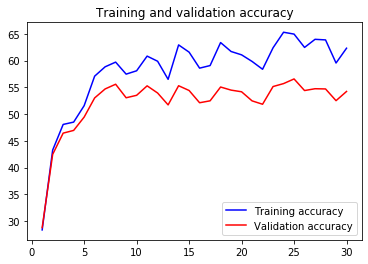

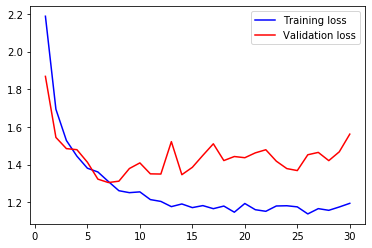

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, 30 + 1)

plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.legend()

plt.show()